# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.358169,True,5.617451
1,1.990848,True,5.883635
2,0.867012,False,0.070445
3,-0.094314,True,4.747691
4,2.109827,True,4.458469
...,...,...,...
995,0.829911,False,-1.473652
996,0.147732,True,3.551253
997,-0.056513,False,0.338218
998,-1.038256,False,1.159471


<AxesSubplot: xlabel='v0'>

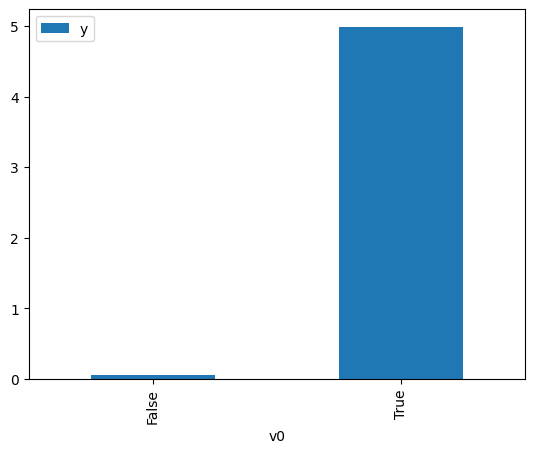

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

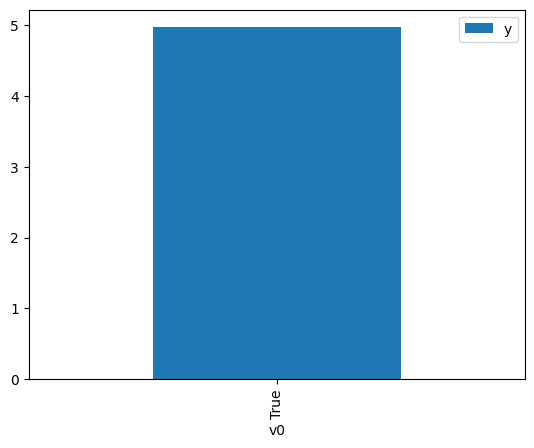

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.967359,False,1.153114,0.331150,3.019782
1,0.763423,False,0.415024,0.367444,2.721504
2,-0.017107,False,-1.574533,0.517087,1.933911
3,0.572470,False,0.826122,0.402856,2.482278
4,-0.145987,False,-0.853886,0.542238,1.844208
...,...,...,...,...,...
995,-0.348021,False,0.960904,0.581189,1.720610
996,-0.523650,False,-2.005070,0.614263,1.627967
997,0.845820,False,-0.093391,0.352570,2.836313
998,2.097017,False,-0.919759,0.169649,5.894523


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.866355,True,5.014511,0.803353,1.244783
1,1.443695,True,4.315689,0.745777,1.340883
2,2.431857,True,4.187088,0.864183,1.157162
3,1.765354,True,4.378604,0.790550,1.264941
4,2.635483,True,6.177609,0.881846,1.133985
...,...,...,...,...,...
995,0.779226,True,4.637006,0.635429,1.573739
996,-0.237416,True,4.108832,0.440041,2.272514
997,0.742948,True,5.822929,0.628819,1.590282
998,1.117563,True,3.892358,0.694381,1.440132


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              8534.
Date:                Fri, 10 Feb 2023   Prob (F-statistic):                        0.00
Time:                        14:39:37   Log-Likelihood:                         -1387.1
No. Observations:                1000   AIC:                                      2778.
Df Residuals:                     998   BIC:                                      2788.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0131      0.031     -0.424      0.672      -0.074       0.048
x2             4.9845      0.053     93.433      0.000       4.880       5.089
==============================================================================
Omnibus:                        7.284   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                9.760
Skew:                           0.034   Prob(JB):                      0.00760
Kurtosis:                       3.479   Cond. No.                         2.88
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""